In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project = project_id)

Authenticated


**Data Pre-Processing**: A BQ table was constructed from several Kaggle sets using SQL. These fields were calculated:

1.  customer_key - unique ID of customer
2.  so_number_count - count of orders placed by a customer
3.  unit_price_sum - net amount spent by each customer
4.  recency_day - days since last order

In [ ]:
%%bigquery rfm_df --project [project name]
select * from [project name].[dataset_name].[table_name]

In [ ]:
#load table values into Pandas dataframe
rfm_df.shape

In [ ]:
#rename columns to use industry standard labels
rfm_df.rename({'so_number_count':'frequency', 'unit_price_sum':'monetary', 'recency_day':'recency'}, axis='columns', inplace=True)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
rfm_df.dtypes

customer_key    object
frequency        Int64
monetary        object
recency          Int64
dtype: object

In [ ]:
#Cast field as numeric
rfm_df['monetary'] = pd.to_numeric(rfm_df['monetary'],errors = 'coerce')

In [ ]:
#Use QCut() to break up customers into quantiles based on "monetary" values.
rfm_df["monetary_score"] = pd.qcut(rfm_df["monetary"], 5, labels=[1, 2, 3, 4, 5])

In [ ]:
#Use QCut() to break up customers into quantiles based on "frequency" values.
rfm_df["frequency_score"] = pd.qcut(rfm_df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [ ]:
#Use QCut() to break up customers into quantiles based on "frequency" values.rfm_df

In [ ]:
#Use QCut() to break up customers into quantiles based on "recency" values.
rfm_df["recency_score"] = pd.qcut(rfm_df["recency"], 5, labels=[5, 4, 3, 2, 1])
rfm_df

In [ ]:
#Create final RFM score by concatenating "recency_score" and "frequency_score"
#In Marketing Science, the preference is given to the frequency and recency score rather than to the monetary score.
#This is because customers who engage with a company are more likely to generate revenue in the future.
#Therefore, for RFM segmenation, "monetary score" is left out.
rfm_df["RFM_SCORE"] = (rfm_df["recency_score"].astype(str) + rfm_df["frequency_score"].astype(str))

In [ ]:
# Create segemnation based on RFM_Score using Regex expression. These segments can be customized for each company. I used segements based on one marketing study.
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_df['segment'] = rfm_df['RFM_SCORE'].replace(seg_map, regex=True)

In [ ]:
#Count customers based on Segements
rfm_by_segmet = rfm_df.groupby("segment")["RFM_SCORE"].count()

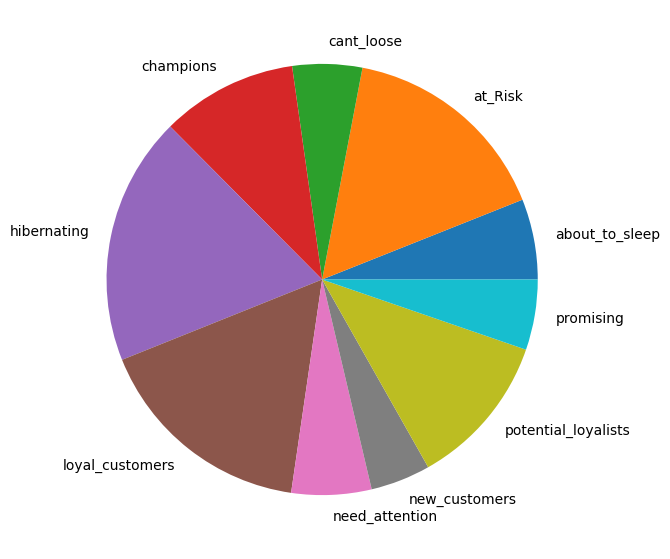

In [ ]:
#Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(rfm_by_segmet, labels = rfm_by_segmet.index)

# show plot
plt.show()

**Customer Live Time Values (CLTV) Calculations**

CLTV = (Customer Value / Churn Rate) * ProfitMargin


In [ ]:
# Calculate the average order value
rfm_df["Average_Order_Value"] = rfm_df["monetary"] / rfm_df["frequency"]

# Calculate customer value
rfm_df["CV"] = rfm_df["Average_Order_Value"] * rfm_df["frequency"]

In [ ]:
# Calculate churn rate: Number of Customers with frequency greater than 1 divided by number of customers

Repeat_Rate = rfm_df[rfm_df["frequency"] > 1].shape[0] / rfm_df.shape[0]

Churn_Rate = 1 - Repeat_Rate

print("Repeat_Rate: ", Repeat_Rate)
print("Churn_Rate: ", Churn_Rate)

In [ ]:
# Calculate profit margin
rfm_df["Profit_Margin"] = rfm_df["monetary"] * 0.10

# Calculate the customer lifetime value using this formula: CLTV = (Customer Value / Churn Rate) * ProfitMargin
rfm_df["CLTV"] = (rfm_df["CV"] / Churn_Rate) * rfm_df["Profit_Margin"]